### Mount Drive and import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import shutil
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchsummary import summary
from skimage.util import random_noise

np.random.seed(0)

Mounted at /content/drive


### Load Dataset

In [ ]:
# Dataset Preparation

#mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
#std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    #transforms.Normalize(mean, std)
])

full_train = datasets.CIFAR10('../data', train=True, download=True,
                   transform=transform_train)

val_size = int(0.1 * len(full_train))                                             # 10% validation
train_size = len(full_train) - val_size

# Train, Test and Val dataset

train_dataset, val_dataset = random_split(
    full_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

test_dataset = datasets.CIFAR10('../data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.RandomCrop(32, padding=4),
                       transforms.ToTensor(),
                       #transforms.Normalize(mean, std)
                   ]))

# Data loaders

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=1024, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=1024, shuffle=False)

# Manifold data loader
manifold_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))


# Save train, test and val image paths and labels in csv files

def save_split_to_csv(split_dataset, filename):
    if isinstance(split_dataset, torch.utils.data.Subset):
      indices = split_dataset.indices
      original_dataset = split_dataset.dataset
      samples = [(original_dataset.data[i],
                  original_dataset.targets[i]) for i in indices]
    else:
      samples = [(split_dataset.data[i],
                  split_dataset.targets[i]) for i in range(len(split_dataset))]
    df = pd.DataFrame(samples, columns=['image_path', 'label'])
    df.to_csv(filename, index=False)

# Save each split

save_split_to_csv(train_dataset, "/content/train_dataset.csv")
save_split_to_csv(val_dataset, "/content/val_dataset.csv")
save_split_to_csv(test_dataset, "/content/test_dataset.csv")

100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]


Train size: 45000
Validation size: 5000
Test size: 10000


### Load ResNet18 trained model

In [ ]:
# Model evaluation using Testing dataset

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1, reduction='sum')

def model_evaluation(model, device, test_loader, epoch):                          # Obtain testing accuracies of the trained model
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            running_loss += test_loss.item()
            total += target.size(0)

    avg_loss = running_loss / total
    accuracy = 100. * correct / total

    print('\nTest set epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return avg_loss, accuracy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 model

model = models.resnet18(weights=None)

model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = torch.nn.Identity()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(num_ftrs, 10)
)

# Load the saved state dictionary into the model
model_path = '/ResNet_model_weights_with_Adam.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

test_loss, test_acc = model_evaluation(model, device, test_loader, epoch=1)

print(f'\nAccuracy of the loaded model on the test dataset: {test_acc:.2f}%')


Test set epoch 1: Average loss: 0.6617, Accuracy: 9387/10000 (94%)


Accuracy of the loaded model on the test dataset: 93.87%


### Selecting Samples from testing set with accuaracy of 100%
- Considered manifold_data_loader which is containing all the images of test dataset

In [ ]:
def get_correct_predictions(model, device, data_loader):
  images, labels = next(iter(data_loader))
  correct_predictions = []
  correct_labels = []
  for image, label in zip(images, labels):
    image = image.to(device).unsqueeze(0)
    label = label.to(device)
    output = model(image)
    _, predicted = torch.max(output, 1)
    if predicted == label:
      correct_predictions.append(image.squeeze(0).cpu())
      correct_labels.append(label.cpu())
  return correct_predictions, correct_labels


correct_predictions, correct_labels = get_correct_predictions(model, device, manifold_data_loader)
print(f'Number of correct predictions: {len(correct_predictions)}')

Number of correct predictions: 9401


### Inital dataset with original images

In [ ]:
# New data loader for correctly predicted images
correct_dataset = torch.utils.data.TensorDataset(torch.stack(correct_predictions), torch.stack(correct_labels))
correct_loader = torch.utils.data.DataLoader(correct_dataset, batch_size=len(correct_dataset), shuffle=False)

# Save the data loader in drive
torch.save(correct_loader, '/Selected_images/correct_loader.pth')

# Load the data loader from drive
correct_loader = torch.load('/Selected_images/correct_loader.pth', weights_only=False)

test_loss, test_acc = model_evaluation(model, device, correct_loader, epoch=1)

print(f'\nAccuracy of the loaded model on the created new dataset: {test_acc:.2f}%')



Test set epoch 1: Average loss: 0.5159, Accuracy: 9401/9401 (100%)


Accuracy of the loaded model on the created new dataset: 100.00%


### Apply Gaussian Noise to create perturbed images
- applyGN(data_loader, sd) function apply random Gaussian corruptions for the input images. We keep mean as 0.

In [ ]:
# Model evaluation

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1, reduction='sum')

def model_evaluation(model, device, test_loader, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            running_loss += test_loss.item()
            total += target.size(0)

    avg_loss = running_loss / total
    accuracy = 100. * correct / total

    #print('\nTest set epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        #epoch, avg_loss, correct, len(test_loader.dataset),
        #100. * correct / len(test_loader.dataset)))
    return avg_loss, accuracy

In [ ]:
# Load the data loader from drive
correct_loader = torch.load('/Selected_images/correct_loader.pth', weights_only=False)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 model
model = models.resnet18(weights=None)

model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = torch.nn.Identity()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(num_ftrs, 10)
)

# Load the saved state dictionary into the model
model_path = '/Model/ResNet_model_weights_with_Adam.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# Check accuracy
test_loss, test_acc = model_evaluation(model, device, correct_loader, epoch=1)
print(f'\nAccuracy of the loaded model on the created new dataset: {test_acc:.2f}%')

def applyGN(correct_loader, sd): # var = standard deviation
  all_gn_images = []
  all_gn_labels = []
  for data in correct_loader:
    img, label = data[0], data[1]
    img_np = img.numpy()
    gauss_img_np = random_noise(img_np, mode='gaussian', mean=0, var=sd, clip=True)
    gauss_img = torch.tensor(gauss_img_np, dtype=torch.float32)
    all_gn_images.append(gauss_img)
    all_gn_labels.append(label)
  gn_images = torch.cat(all_gn_images, dim=0)
  gn_labels = torch.cat(all_gn_labels, dim=0)
  return gn_images, gn_labels


# sds
sds = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 1.00]


for sd in sds:
  # applyGN now returns concatenated tensors
  gn_images, gn_labels = applyGN(correct_loader, sd)
  gn_dataset = torch.utils.data.TensorDataset(gn_images, gn_labels)
  gn_loader = torch.utils.data.DataLoader(gn_dataset, batch_size=len(gn_dataset), shuffle=False)

  # Save the data loader in drive after applying Gaussian Noise
  torch.save(gn_loader, f'/Selected_images/gn_{sd}_loader.pth')

  # Check test accuracy for each Gaussian Curruptions
  test_loss, test_acc = model_evaluation(model, device, gn_loader, epoch=1)
  print(f'\nAccuracy of the loaded model on a dataset with Gaussian Noise of {sd} : {test_acc:.2f}%')


Accuracy of the loaded model on the created new dataset: 100.00%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.0001 : 98.93%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.0005 : 95.38%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.001 : 89.77%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.005 : 51.13%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.01 : 30.59%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.05 : 13.22%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.1 : 11.29%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.25 : 9.91%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.5 : 9.74%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.75 : 9.78%

Accuracy of the loaded model on a dataset with Gaussian Noise of 1.0 : 9.74%


### Visualize images and predicted labels

In [ ]:
!ls '/Selected_images/'


correct_loader.pth    gn_0.005_loader.pth  gn_0.25_loader.pth
gn_0.0001_loader.pth  gn_0.01_loader.pth   gn_0.5_loader.pth
gn_0.0005_loader.pth  gn_0.05_loader.pth   gn_0.75_loader.pth
gn_0.001_loader.pth   gn_0.1_loader.pth    gn_1.0_loader.pth


Predicted: 8, Actual: 8
Predicted: 8, Actual: 8
Predicted: 8, Actual: 8
Predicted: 8, Actual: 8
Predicted: 8, Actual: 8
Predicted: 1, Actual: 8
Predicted: 2, Actual: 8
Predicted: 1, Actual: 8
Predicted: 9, Actual: 8
Predicted: 9, Actual: 8
Predicted: 5, Actual: 8
Predicted: 8, Actual: 8


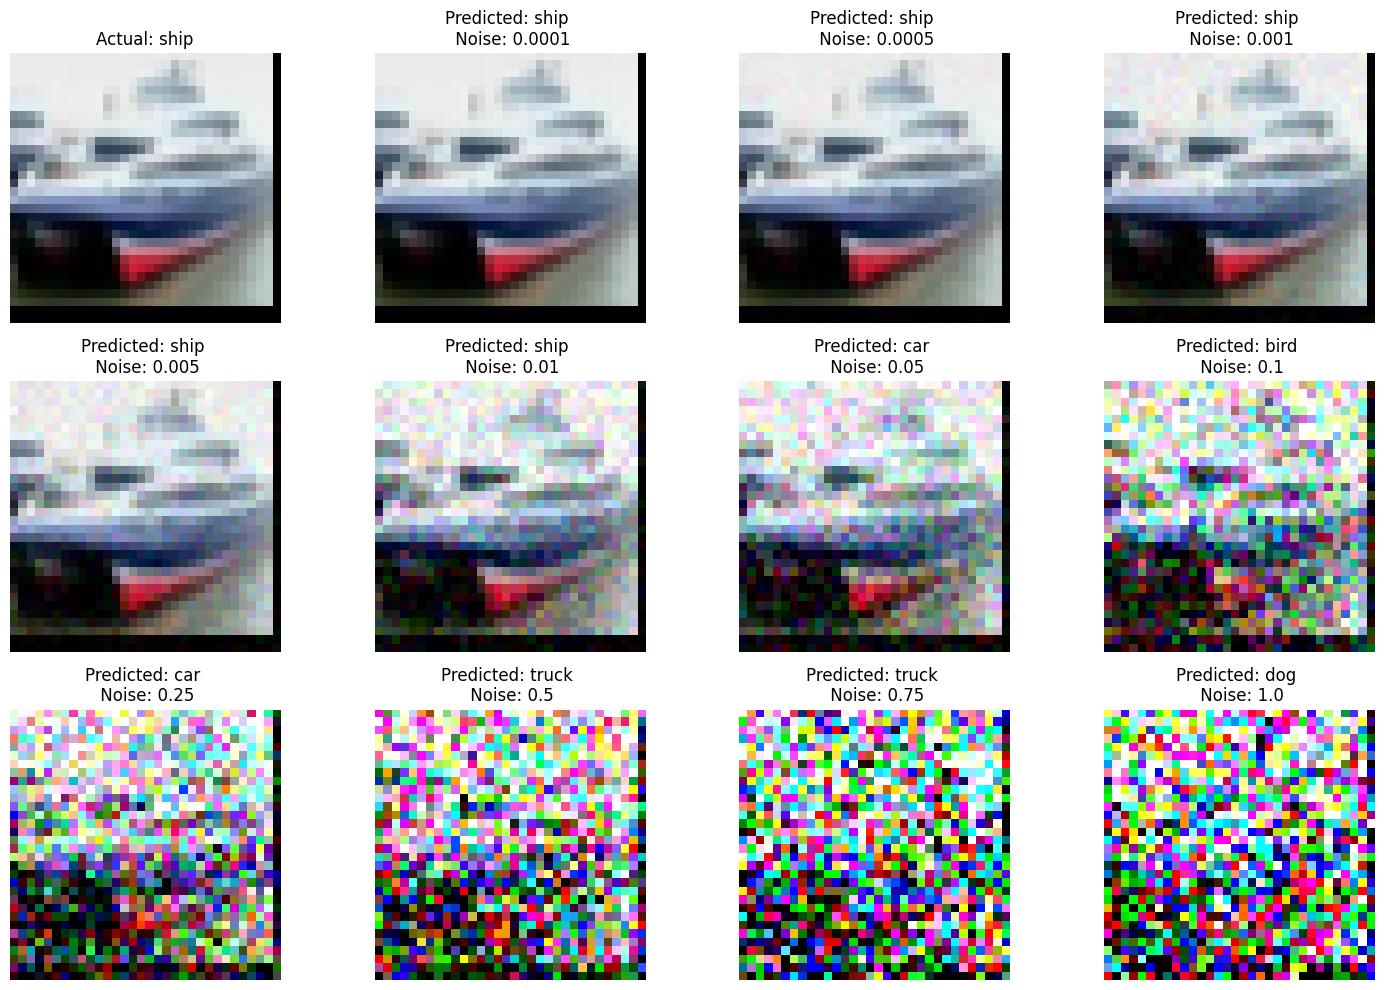

In [ ]:
# Load data loaders
path = '/Selected_images/'
data_loaders = []
for file in os.listdir(path):
  if file.endswith('.pth'):
    data_loaders.append(torch.load(os.path.join(path, file), weights_only=False))

# Gaussian noise levels
gaussian_noises = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 1.00]

# Load ResNet18 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=None)

model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = torch.nn.Identity()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(num_ftrs, 10)
)

model_path = '/Model/ResNet_model_weights_with_Adam.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)

# Select first 10 images' indexes where model gives correct predictions
img_indexes = []
correct_images_batch, correct_labels_batch = next(iter(correct_loader))
for i, img in enumerate(correct_images_batch):
  img = img.to(device).unsqueeze(0)
  label = correct_labels_batch[i].to(device)
  output = model(img)
  _, predicted = torch.max(output, 1)
  if predicted == label:
    img_indexes.append(i)
    if len(img_indexes) == 10:
      break

# Get prediction for the first image of each data loader

images = []
correct_labels = []
predicted_labels = []

# Select random image from img_indexes
import random
img_index = img_indexes[random.randint(0,len(img_indexes) -1)]

for data_loader in data_loaders:
  images_batch, labels_batch = next(iter(data_loader))
  image = images_batch[img_index]
  label = labels_batch[img_index]
  image = image.to(device).unsqueeze(0)
  label = label.to(device)
  output = model(image)
  _, predicted = torch.max(output, 1)
  images.append(image.squeeze(0).cpu())
  correct_labels.append(label.cpu())
  predicted_labels.append(predicted.cpu())
  print(f'Predicted: {predicted.item()}, Actual: {label.item()}')

# classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Visuallize images, actual label, predicted label, and Gaussian noise lavel
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axs.flat):
  if i == 0:
    ax.imshow(correct_images_batch[img_index].permute(1, 2, 0))
    ax.set_title(f'Actual: {classes[correct_labels_batch[img_index].item()]}')
  else:
    ax.imshow(images[i-1].permute(1, 2, 0))
    ax.set_title(f'Predicted: {classes[predicted_labels[i-1].item()]} \n Noise: {gaussian_noises[i-1]}')
  ax.axis('off')
plt.tight_layout()
plt.show()